A Study of Support Vector Machines                        
----                                                               
Data Mining in Social Networks 

Author: Carson Hanel    

Professor: Eduardo Nakamura       

a) Create a training data set with 200 random samples. Plot the training observations, colored according to their class labels. Your plot should display X1 on the x-axis, and X2 on the y-axis.
----

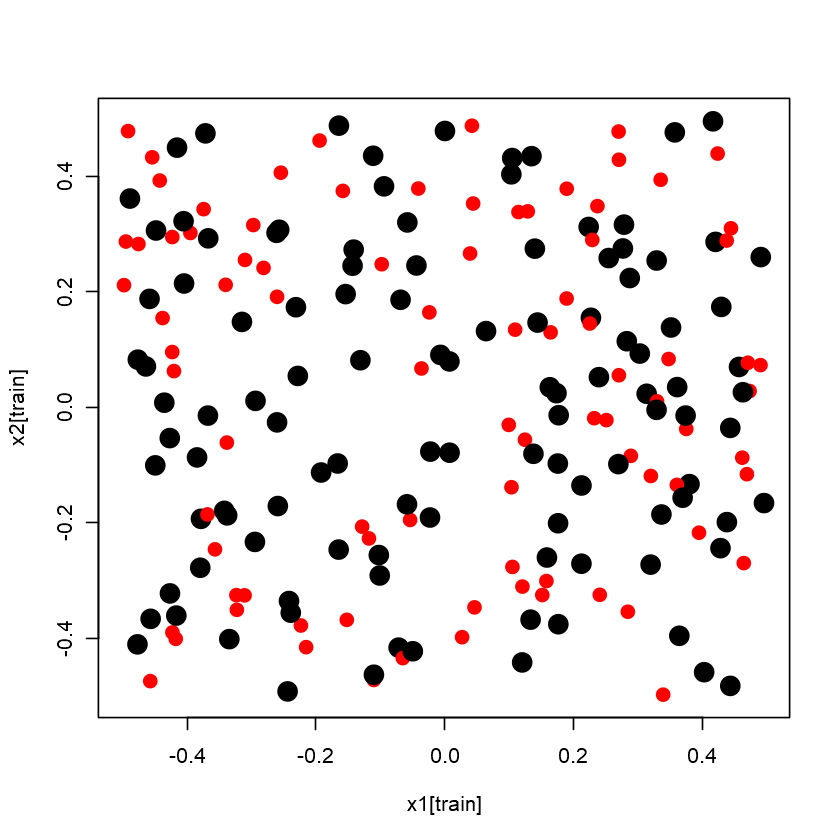

In [20]:
set.seed(1)
x1=runif(1000)-0.5
x2=runif(1000)-0.5
y=1*(x1^2-x2^2>0)
train=sample(1000,200)
plot(x1[train], x2[train], col=(y+1), pch=(y+19), cex=2)

Prepare the data for the SVM, and import the necessary libraries
----

In [11]:
# Acquisition of libraries
install.packages("e1071", repos='http://cran.us.r-project.org')
install.packages("caret", repos='http://cran.us.r-project.org')
library(e1071)
library(caret)

package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Jeff\AppData\Local\Temp\RtmpoTUnEZ\downloaded_packages
package 'caret' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Jeff\AppData\Local\Temp\RtmpoTUnEZ\downloaded_packages


Loading required package: lattice
Loading required package: ggplot2


In [31]:
# Preparation of data.
# Bind x1, x2 into a column matrix, print it out (optionally)
x = cbind(x1, x2)

# Create a dataframe, print it out (optionally)
dat = data.frame(x=x, y=as.factor(y))

b) Fit a support vector classifier (tuned) to the data with X1 and X2 as predictors. Obtain a class prediction for each test observation. Plot the training and test observations, colored according to the predicted class labels
----
Here, I'll be outputting the results from the tuning of the linear kernel, and plotting. As you can see, it's an awful fit, but the F1 recall looks semi-decent. This is because the results are entirely comprised of true positives, and false positives. The intuition behind this is that essentially, the linear kernel SVM considered the entire graph space to be the dominant class in the training dataset, which allowed for quite misleading results, and is completely unusable when trying to transfer the model to another dataset. Essentially, this is only slightly better than random chance to identify the correct classification of data.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
  cost
 0.001

- best performance: 0.47 

- Detailed performance results:
   cost error dispersion
1 1e-03 0.470  0.1159502
2 1e-02 0.470  0.1159502
3 1e-01 0.500  0.1054093
4 1e+00 0.505  0.1116791
5 1e+01 0.505  0.1116791
6 1e+02 0.505  0.1116791
7 1e+03 0.505  0.1116791


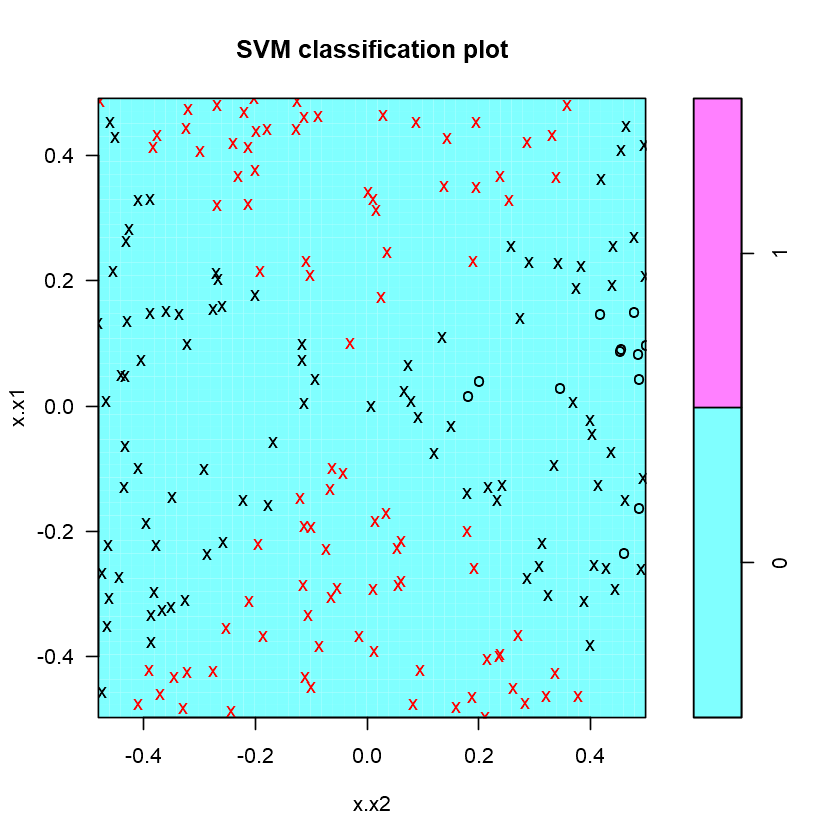

In [45]:
# Tune the SVM, output the results
tl.out=tune(svm, y~., data=dat[train,], kernel="linear", ranges=list(cost=10^(-3:3)))
summary(tl.out)
bestl = tl.out$best.model
plot(bestl, dat[train,])

Utilize the linear fit to predict all elements of the training and test set data.
----

In [47]:
# Get predictions for training set
lin_train_ypred = predict(bestl, newdata=dat[train,])
train           = table(predict=lin_train_ypred, truth=dat[train, "y"])

# Get predictions for test set
lin_test_ypred  = predict(bestl, newdata=dat[-train,])
actual          = table(predict=lin_test_ypred, truth=dat[-train, "y"])

actual

       truth
predict   0   1
      0 527 472
      1   0   0

Plot the testing predictions for Linear Kernel:
----

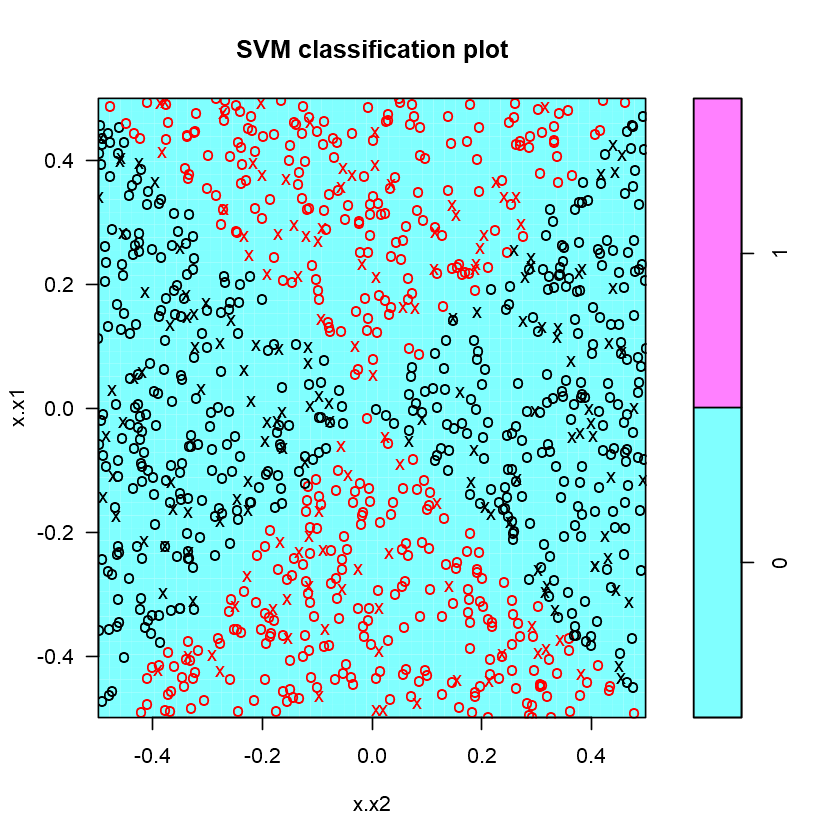

In [48]:
# Plot testing set
plot(bestl, dat[-train,])

Analyze the F1 Recall of the Linear fit:
----

In [49]:
# F1 recall
TP        = actual[1][1]
FP        = actual[3][1]
FN        = actual[2][1]
TN        = actual[4][1]
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_recall = 2 * ((precision * recall)/(precision + recall))
f1_recall

[1] 0.6906946

Discuss the findings of the Linear fit:
----
Essentially, rerunning the experiment with different random seeds gives one of two results: Either all true positive, false positive, or true negative and false negative. This seems to be effected mostly by the test/train split; essentially, whichever classification has a higher representation in the dataset, that's the one that every element will be classified as. This is awful for situations in which you have more than two classes, and more obviously, when the relationship between two classes can be defined linearly. Unfortunately, in most cases, and the current case, there is overlapping data and classes, so the linear classifier does poorly.

As you can see, there was still a 69% F1 recall, which turns into 0 or NaN if the false negative/positive route is taken
by the support vector machine. This would seem like it's scoring much better than random chance, but unfortunately
true positive and false positive are very heavily weighted metrics for F1, and the others aren't so much so.

Because of this, I'd actually seek other methods of explaining the accurracy. Let's move onto the polynomial kernel.

c) Fit a support vector classifier (tuned) using a polynomial kernel. Obtain a class prediction for each training and test observation. Plot the training and test observations, colored according to predicted class labels.
----
Now we're beginning to see a bit more accurracy with the polynomial fit. Intuitively, our data was created using a
degree 2 polynomial, so it would make sense that the best fit would be, well, a degree 2. The polynomial kernel is a bit better, as it's able to see relationships that are beyond simply linear.

As you'll see, the results from the polynomial kernel will be drastically improved from the linear fit.
What does this mean? Essentially, that the behaviour of the data in this function is such that linearity
cannot find all information, and a polynomial is the next best thing.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost degree
  100      2

- best performance: 0.035 

- Detailed performance results:
    cost degree error dispersion
1    0.1      1 0.590 0.08432740
2    1.0      1 0.560 0.08755950
3   10.0      1 0.555 0.08316650
4  100.0      1 0.555 0.08316650
5    0.1      2 0.085 0.06258328
6    1.0      2 0.055 0.04377975
7   10.0      2 0.045 0.02838231
8  100.0      2 0.035 0.03374743
9    0.1      3 0.525 0.13176157
10   1.0      3 0.465 0.09442810
11  10.0      3 0.510 0.11005049
12 100.0      3 0.510 0.11005049


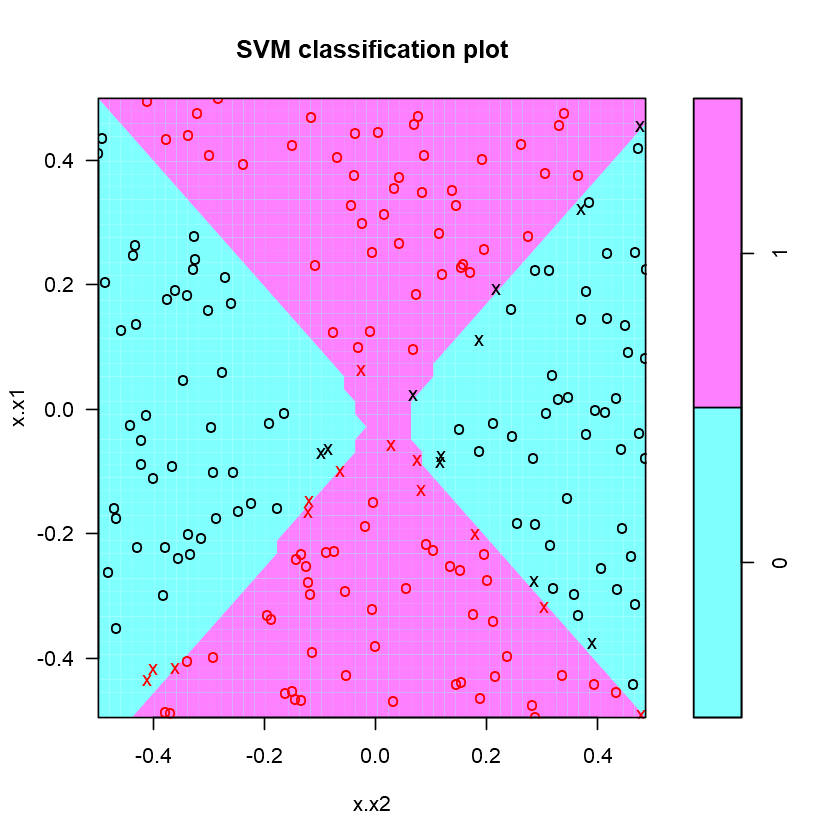

In [58]:
# Tune the SVM, output the results
train=sample(1000,200)
tp.out=tune(svm, y~., data=dat[train,], kernel="polynomial", ranges=list(cost=10^(-1:2), degree=(1:3)), cross=10)
summary(tp.out)
bestp = tp.out$best.model
plot(bestp, dat[train,])

Utilize the polynomial fit to predict all elements of the training and test set data.
----

In [59]:
# Get predictions for training set
poly_train_ypred = predict(bestp, newdata=dat[train,])
train            = table(predict=poly_train_ypred, truth=dat[train, "y"])

# Get predictions for test set
poly_test_ypred  = predict(bestp, newdata=dat[-train,])
actual           = table(predict=poly_test_ypred, truth=dat[-train, "y"])
actual

       truth
predict   0   1
      0 502  12
      1  25 458

Plot the testing predictions for Polynomial Kernel:
----

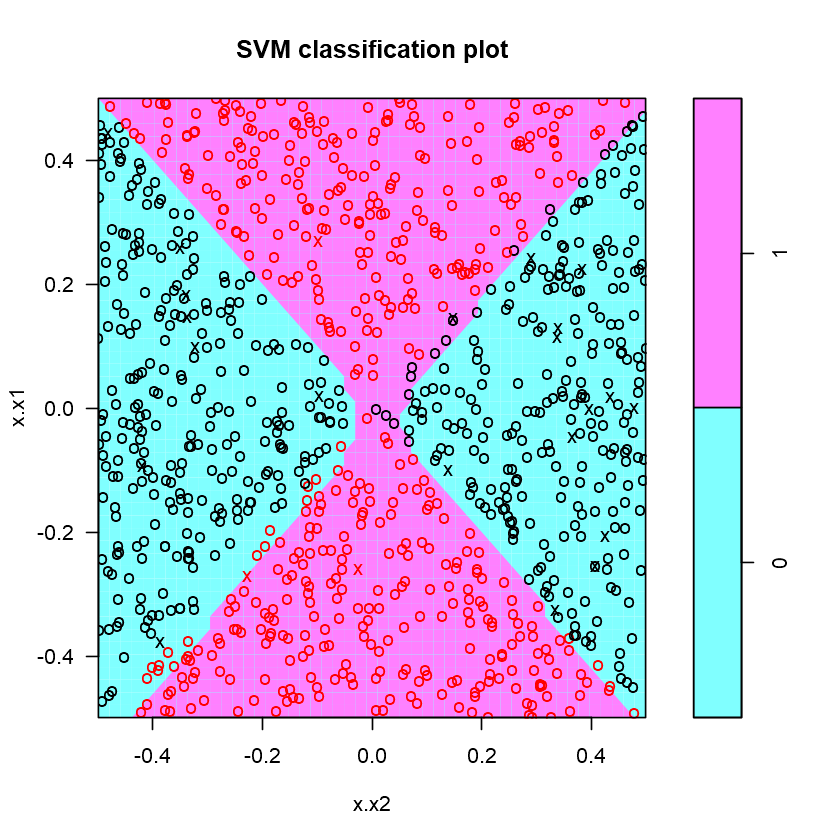

In [60]:
# Plot testing set
plot(bestp, dat[-train,])

Analyze the F1 Recall of the Polynomial fit:
----

In [61]:
# F1 recall
TP        = actual[1][1]
FP        = actual[3][1]
FN        = actual[2][1]
TN        = actual[4][1]
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_recall = 2 * ((precision * recall)/(precision + recall))
f1_recall

[1] 0.9644573

Discuss the findings of the Polynomial fit:
----
In the fitting of the polynomial, the best cost for the dataset was 100 (the highest) and the degree of the function was 2.
This is good, sensical news because we'd created the dataset using a degree 2 polynomial formula. A high cost rather
than a low cost penalizes reactions to the fitting of new data heavily, which would lean to the idea that there is sufficient
data to fit cleanly the dataset. In this case, you'd think that the polynomial kernel would perform best, but return to the above plot and focus in on the area closest to the middle of the graph. In the actual plot of the generated data, with perfect resolution (unlimited data), the function makes a perfect "X". Because there are few points, and many are required to fully flesh out the "X" bound, that section of the graph was designated as the "pink" class, when really at much higher resolution it must share that area with the "blue" class.

Essentially, this is an overfit to the given data. In this situation, it works very well, but at scale there are many more false positives and negatives because of this region. Notice, too, that the "pink" classification is tailored very tightly, and lots of the data is being misclassified very, very closely to the boundary between the two classes.

Intuitively, it might make the most sense to go with a polynomial kernel for a polynomial function, but let's check out
the radial fit.

d) Fit a support vector classifier (tuned) using a radial kernel. Obtain a class prediction for each training and test observation. Plot the training and test observations, colored according to predicted class labels.
----
Unlike a polynomial kernel, the radial kernel completely throws away linearity, and is a bit closer to
a clustering analysis than linear. It might be the most sensical thing to believe that the polynomial
kernel would fit a polynomial very well, but when data are sparse, sometimes (and in the current case),
the radial kernel keeps from overfitting, and is less exact as the polynomial fit, but to its advantage.

As you'll see, the highest F1 recall was with the radial kernel. We'll see how it measures up otherwise.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
  100   0.5

- best performance: 0.04 

- Detailed performance results:
    cost gamma error dispersion
1    0.1   0.5 0.140 0.06146363
2    1.0   0.5 0.100 0.08164966
3   10.0   0.5 0.070 0.05374838
4  100.0   0.5 0.040 0.03944053
5    0.1   1.0 0.110 0.07378648
6    1.0   1.0 0.090 0.08432740
7   10.0   1.0 0.075 0.04859127
8  100.0   1.0 0.050 0.04082483
9    0.1   2.0 0.120 0.08881942
10   1.0   2.0 0.080 0.05374838
11  10.0   2.0 0.070 0.04830459
12 100.0   2.0 0.065 0.06258328
13   0.1   3.0 0.115 0.08514693
14   1.0   3.0 0.080 0.04830459
15  10.0   3.0 0.085 0.05797509
16 100.0   3.0 0.075 0.06770032
17   0.1   4.0 0.120 0.06324555
18   1.0   4.0 0.080 0.04216370
19  10.0   4.0 0.085 0.05797509
20 100.0   4.0 0.070 0.05868939


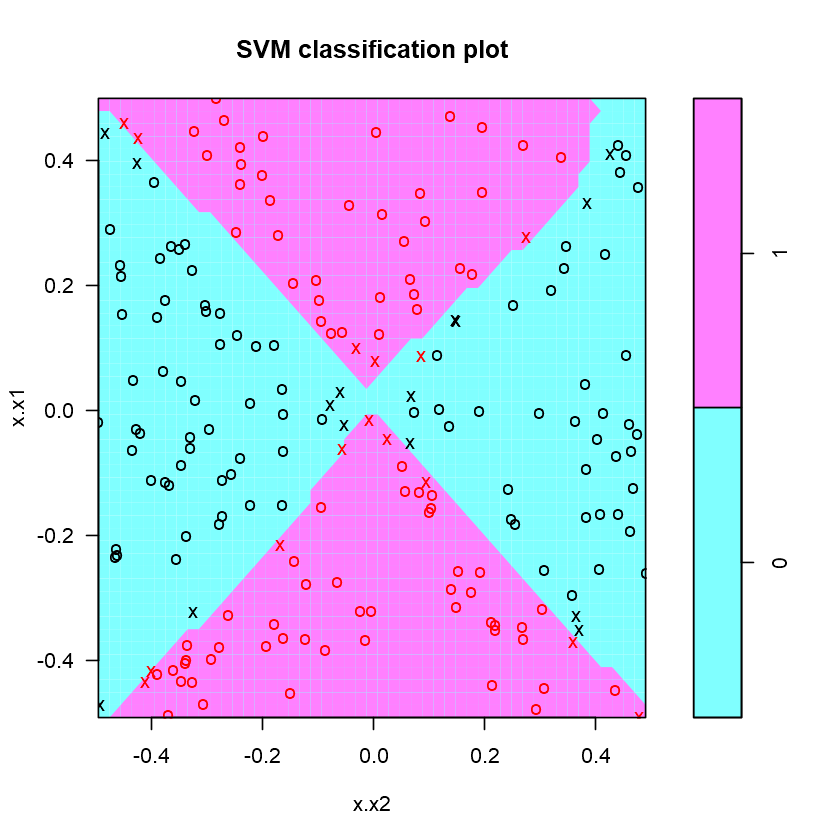

In [62]:
# Tune the SVM, output the results
train=sample(1000,200)
tr.out=tune(svm, y~., data=dat[train,], kernel="radial", ranges=list(cost=10^(-1:2), gamma=c(0.5, 1:4)))
summary(tr.out)
bestr = tr.out$best.model
plot(bestr, dat[train,])

Utilize the radial fit to predict all elements of the training and test set data.
----

In [63]:
# Get predictions for training set
radial_train_ypred = predict(bestr, newdata=dat[train,])
test   = table(predict=radial_train_ypred, truth=dat[train, "y"])

# Get predictions for test set
radial_test_ypred  = predict(bestr, newdata=dat[-train,])
actual = table(predict=radial_test_ypred, truth=dat[-train, "y"])
actual

       truth
predict   0   1
      0 415   8
      1  10 367

Plot the testing predictions for Radial Kernel:
----

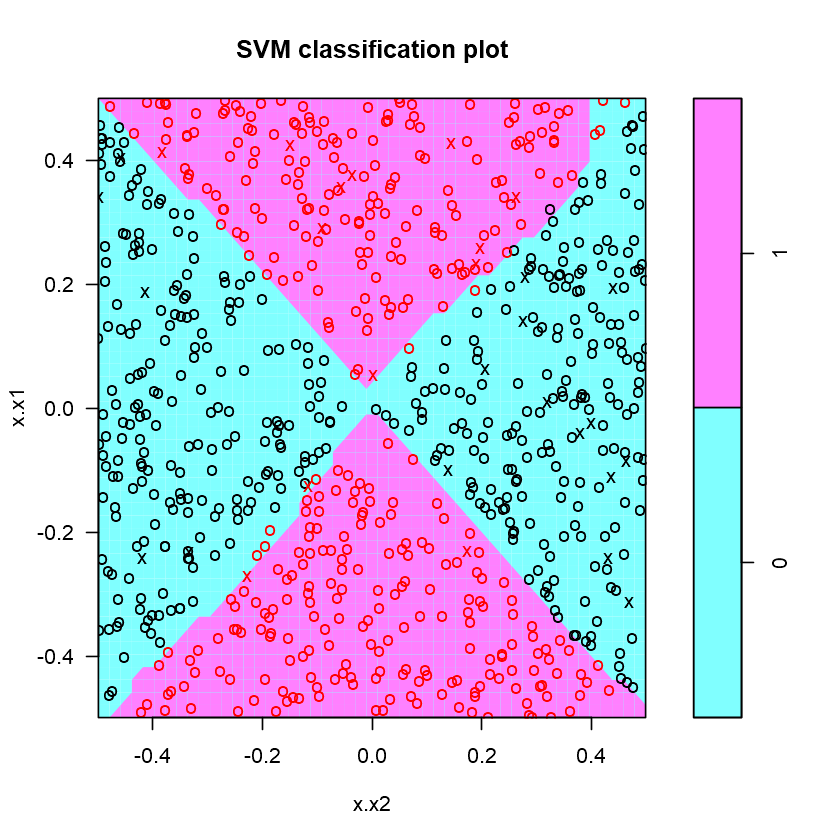

In [64]:
# Plot testing set
plot(bestr, dat[-train,])

Analyze the F1 Recall of the Radial fit:
----

In [65]:
# F1 recall
TP        = actual[1][1]
FP        = actual[3][1]
FN        = actual[2][1]
TN        = actual[4][1]
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_recall = 2 * ((precision * recall)/(precision + recall))
f1_recall 

[1] 0.9787736

Discuss the findings of the Radial fit:
----
Finally, we've reached the radial fit! This was excited, as I'd screwed up the analysis last night and gotten a really,
really, wonky fit. As you can see, the region highlighted in the polynomial fit (the middle, closest to the "X") is much,
much more well defined with a radial kernel, and much fewer of the cases where data on the boundaries was misclassified.

From polynomial to radial, we reduced false positives by around 10, while keeping all other metrics approximately the
same. Looking at the fit graph, it might be your first instinct to point out the a-symmetry of the radial kernel as 
compared to polynomial, and conclude that the polynomial fit is better. This is a case in which knowing your
data is helpful; if you have more centric data, the radial kernel is probably superior, and if your data is more sparse,
but still polynomial, the polynomial fit SVM is superior.

In the end, the polynomial fit scored F1 = 96.4457 and the radial fit scored F1 = 97.877, which is small, but an improvement.

The moral of this assignment is to know your data and how your tools process it.

Extra fun curious stuff that's not graded, but I thought I'd include:
----

Ultra-high resolution fitting:
----

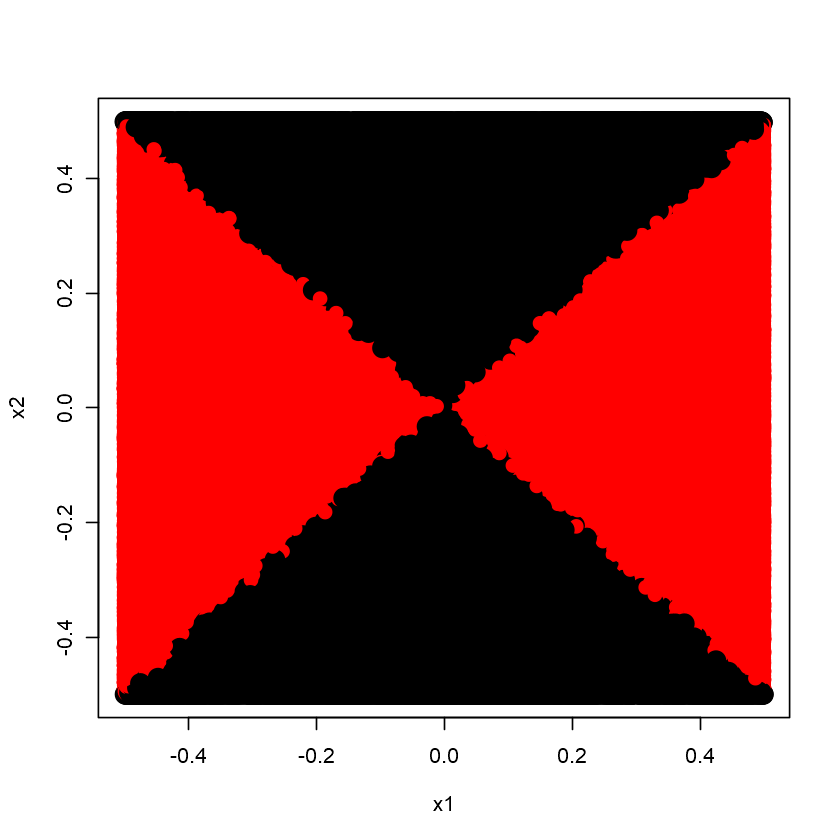

In [66]:
# Generate the data
set.seed(1)
x1=runif(1000000)-0.5
x2=runif(1000000)-0.5
y=1*(x1^2-x2^2>0)

# Check out the resolution of the data.
plot(x1, x2, col=(y+1), pch=(y+19), cex=2)

Create the dataset, predict given the models from the previous analysis:
----

In [67]:
# Create the dataset
x = cbind(x1, x2)
dat = data.frame(x=x, y=as.factor(y))

# Score w/ radial and polynomial
radial_highres  = predict(bestr, dat)
poly_highres    = predict(bestp, dat)
actual_radial   = table(predict=radial_highres, truth=dat[, "y"])
actual_poly     = table(predict=poly_highres, truth=dat[, "y"])

Polynomial F1
----

In [68]:
# F1 for polynomial
TP        = actual_poly[1][1]
FP        = actual_poly[3][1]
FN        = actual_poly[2][1]
TN        = actual_poly[4][1]
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_recall = 2 * ((precision * recall)/(precision + recall))
f1_recall

[1] 0.9549575

Radial F1
----

In [69]:
# F1 for radial
TP        = actual_radial[1][1]
FP        = actual_radial[3][1]
FN        = actual_radial[2][1]
TN        = actual_radial[4][1]
precision = TP / (TP + FP)
recall    = TP / (TP + FN)
f1_recall = 2 * ((precision * recall)/(precision + recall))
f1_recall # .9705018

[1] 0.9713788

As you can see, the radial is a better choice at scale for the function.
----

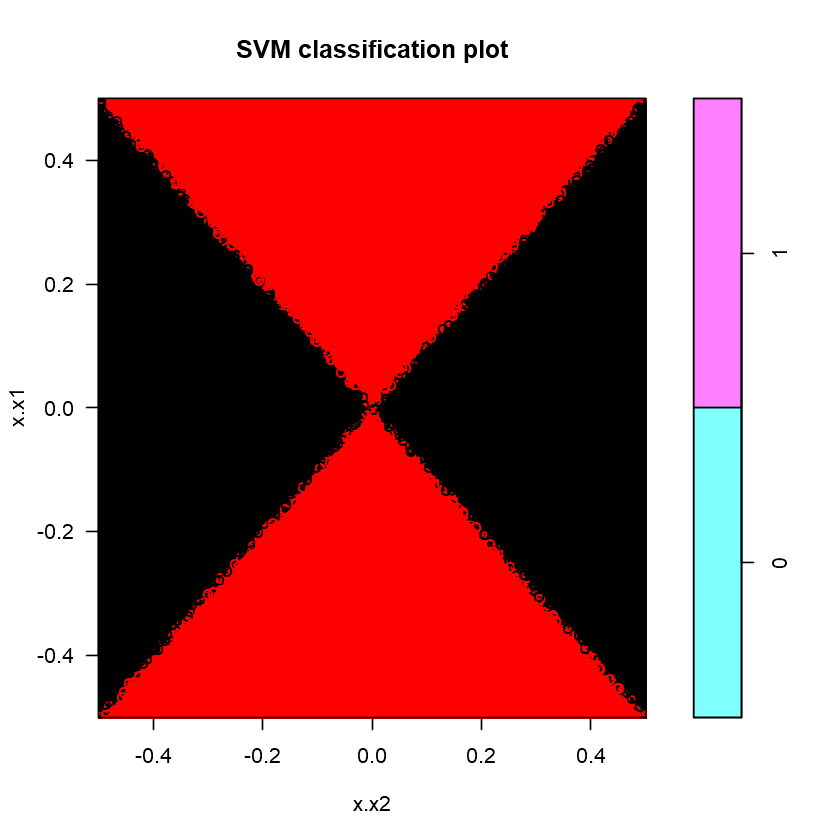

In [71]:
# Plot radial w/ 1,000,000 data pts
# Warning, code takes a second.
plot(bestr, dat)

Thanks for the fun assignment, and if you're reading on GitHub, thanks for reading!
----